<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/drive')
!ls "/content/drive/MyDrive/深度學習 Colab/HW3" # 顯示路徑下所有資料夾與檔案

#!tar -xvf "/content/drive/MyDrive/深度學習 Colab/HW3/bottle.tar.gz" # 解壓縮資料夾才需要

Mounted at /content/drive
Attempt1_unfreeze.ipynb  Attempt3_batch_size.ipynb  bottle
Attempt2_epoch.ipynb	 Attempt4.ipynb		    Origin.ipynb


In [19]:
file_paths = glob.glob("/content/drive/MyDrive/深度學習 Colab/HW3/bottle/**/*.png", recursive=True) # ** 會匹配所有層級的子資料夾


# 從 file_paths 中挑出檔名開頭是 000.png 到 019.png 的圖片，並排序好
file_paths = sorted([
    path for path in file_paths
    if path.split('/')[-1][:3] in [f'{i:03}' for i in range(20)]
])
print(file_paths)

['/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/000_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/001_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/002_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/003_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/004_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/005_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/006_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/007_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/008_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/009_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bottle/ground_truth/broken_large/010_mask.png', '/content/drive/MyDrive/深度學習 Colab/HW3/bot

In [20]:
all_data = []

for img in tqdm(file_paths):
  img = cv2.imread(img)
  img = img[..., ::-1] # ... 表示前面所有維度（height × width），::-1 表示把最後一個維度（色彩通道）反轉
  all_data.append(img)

all_data = np.stack(all_data) # 將 list 中的所有圖片合併成一個 4 維 NumPy 陣列，維度是：(num_images, height, width, channels)
print(all_data.shape) # 現在會有 160 張圖片，因為每個子資料夾都先讀取前 20 張

  0%|          | 0/160 [00:00<?, ?it/s]

(160, 900, 900, 3)


Classes: ['content']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

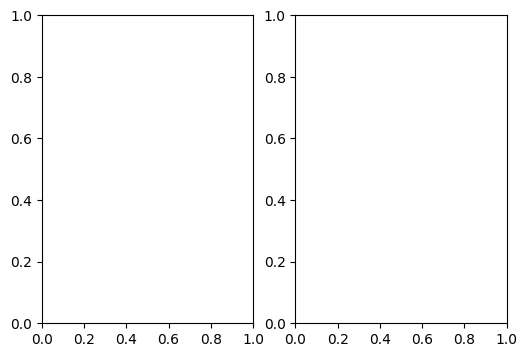

In [42]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[1] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [28]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 3 # 總共 3 類不良
images_per_class = 20 # 每個資料夾讀取前 20 張圖片
train_images_per_class = int(images_per_class * 0.8) # num_images = 60 * 0.8 = 48
val_images_per_class = int(images_per_class * 0.2) # num_images = 60 * 0.2 = 12

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class]) # 前 48 張當作訓練集
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class]) # 剩下當作驗證集

# The shape changes from (num_images, height, width, channels) to (num_images, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (48, 3, 900, 900)
Shape of x_val: (12, 3, 900, 900)
Shape of y_train: (48,)
Shape of y_val: (12,)


In [30]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(), # 50% 機率左右翻轉
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x # (num_images, channels, height, width) 的 NumPy 陣列
        self.y = torch.from_numpy(y).long() # 將標籤陣列轉為 PyTorch tensor，並轉為 long（整數類型，分類常用）
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [31]:
batch_size = 32 # hyper parameter

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [32]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import efficientnet_b0

# ResNet18 換成 EfficientNet_B0
model = efficientnet_b0(pretrained=True)

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.features.parameters():
    param.requires_grad = False

#num_ftrs = model.fc.in_features
num_class = 3

#
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, num_class)
)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## C. Training the Neural Network

In [33]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50 # hyper parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) # hyper parameter
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            images = (images) / 255.
            labels = labels.to(device)
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1.1038, Train acc: 35.4167%, Val loss: 1.0994, Val acc: 33.3333%, Best Val loss: 1.0994 Best Val acc: 33.33%
Epoch 2/50, Train loss: 1.2078, Train acc: 35.4167%, Val loss: 1.0983, Val acc: 33.3333%, Best Val loss: 1.0983 Best Val acc: 33.33%
Epoch 3/50, Train loss: 1.2355, Train acc: 31.2500%, Val loss: 1.1007, Val acc: 33.3333%, Best Val loss: 1.0983 Best Val acc: 33.33%
Epoch 4/50, Train loss: 1.2447, Train acc: 29.1667%, Val loss: 1.1021, Val acc: 33.3333%, Best Val loss: 1.0983 Best Val acc: 33.33%
Epoch 5/50, Train loss: 1.1291, Train acc: 31.2500%, Val loss: 1.1039, Val acc: 33.3333%, Best Val loss: 1.0983 Best Val acc: 33.33%
Epoch 6/50, Train loss: 1.1595, Train acc: 35.4167%, Val loss: 1.1117, Val acc: 33.3333%, Best Val loss: 1.0983 Best Val acc: 33.33%
Epoch 7/50, Train loss: 1.0697, Train acc: 45.8333%, Val loss: 1.1108, Val acc: 33.3333%, Best Val loss: 1.0983 Best Val acc: 33.33%
Epoch 8/50, Train loss: 1.0251, Train acc: 50.0000%, Val loss: 1.1312

### Visualizing model performance

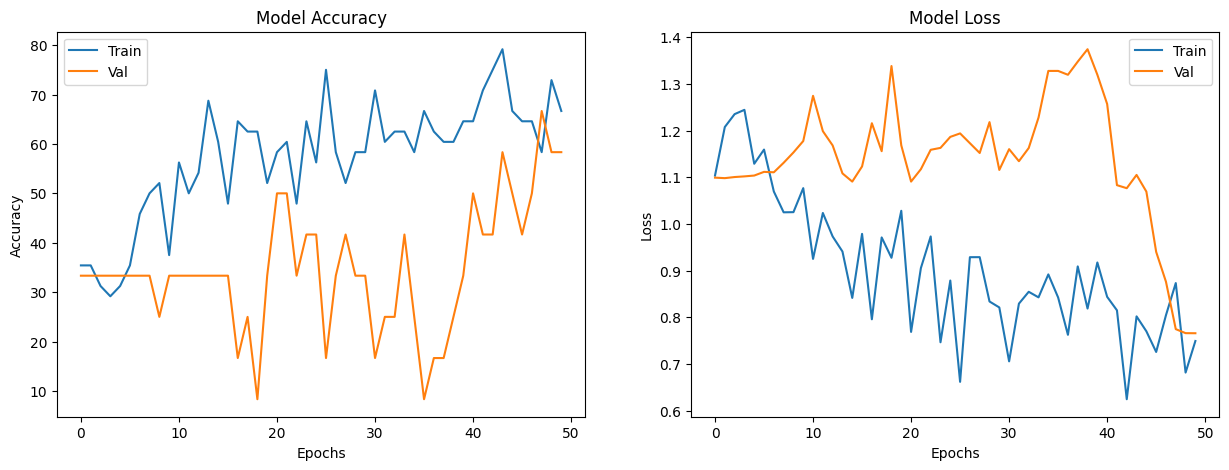

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [36]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.to(device)
        images = (images) / 255.

        labels = labels.to(device)
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
Test accuracy is 66.66666666666667%
